In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow

from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot
from pickle import load

In [2]:
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)

In [3]:
#Parameters
LR = 0.001
BATCH_SIZE = 64
N_EPOCH = 50

input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

### 2. LSTM Model:
**LONG SHORT TERM MEMORY-**
- LSTM has ability of remove and add information to the cell state

In [4]:
def basic_lstm(input_dim, feature_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units= 128), input_shape=(input_dim, feature_size)))
    model.add(Dense(64))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(lr = LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    return model


C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
28/28 - 12s - loss: 0.1491 - val_loss: 0.0363 - 12s/epoch - 414ms/step
Epoch 2/50
28/28 - 1s - loss: 0.0438 - val_loss: 0.0100 - 512ms/epoch - 18ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0202 - val_loss: 0.0633 - 473ms/epoch - 17ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0284 - val_loss: 0.0386 - 488ms/epoch - 17ms/step
Epoch 5/50
28/28 - 1s - loss: 0.0409 - val_loss: 0.0154 - 511ms/epoch - 18ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0151 - val_loss: 0.0045 - 452ms/epoch - 16ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0395 - val_loss: 0.0601 - 479ms/epoch - 17ms/step
Epoch 8/50
28/28 - 0s - loss: 0.1101 - val_loss: 0.0245 - 475ms/epoch - 17ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0368 - val_loss: 0.0229 - 491ms/epoch - 18ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0157 - val_loss: 0.0664 - 459ms/epoch - 16ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0371 - val_loss: 0.0435 - 439ms/epoch - 16ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0051 - val_loss: 0.0342 - 474ms/epoch - 17ms/step
Epoch 13/50
2

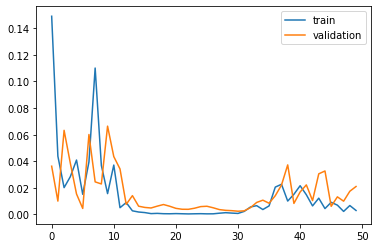

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              168960    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 185,473
Trainable params: 185,473
Non-trainable params: 0
_________________________________________________________________
None
0.14494129644243683


In [5]:
model = basic_lstm(input_dim, feature_size)
model.save('LSTM_3to1.h5')
print(model.summary())

yhat = model.predict(X_test, verbose=0)
#print(yhat)

rmse = sqrt(mean_squared_error(y_test, yhat))
print(rmse)


### Train Data

In [6]:
# %% --------------------------------------- Plot the TRAIN result  -----------------------------------------------------------------
## TRAIN DATA
def plot_traindataset_result(X_train, y_train):


    train_yhat = model.predict(X_train, verbose=0)

    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    train_predict_index = np.load("index_train.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_train)
    rescaled_predicted_y = y_scaler.inverse_transform(train_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
    #
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)
    #
    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Train RMSE -- ', RMSE)

    return RMSE

### Test data

In [7]:
# %% --------------------------------------- Plot the TEST result  -----------------------------------------------------------------
def plot_testdataset_result(X_test, y_test):

    test_yhat = model.predict(X_test, verbose=0)
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("index_test.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    Input_Before = '2020-01-01'
    predict_result = predict_result.loc[predict_result.index < Input_Before]
    real_price = real_price.loc[real_price.index < Input_Before]

    print(predict_result.tail(10))

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Test RMSE -- ', RMSE)

    return RMSE

In [8]:
def plot_testdataset_with2020_result(X_test, y_test):


    test_yhat = model.predict(X_test, 1, verbose=0)

    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing with 2020", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Test RMSE with 2020 -- ', RMSE)

    return RMSE

### Train RMSE LSTM plot
- **Root-mean-square deviation**

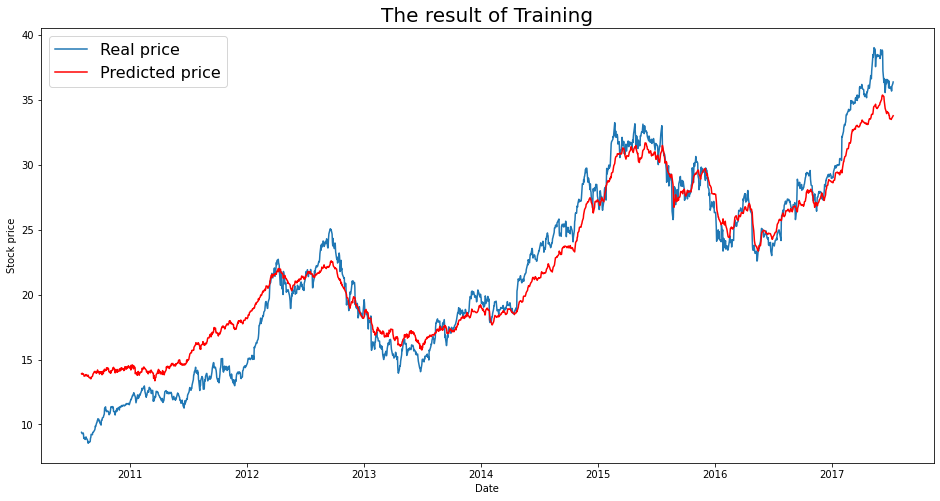

----- Train_RMSE_LSTM ----- 1.8934999068024119


In [9]:
train_RMSE = plot_traindataset_result(X_train, y_train)
print("----- Train_RMSE_LSTM -----", train_RMSE)

### Test RMSE LSTM plot

            predicted_price  predicted_price  predicted_price  \
2019-12-17              NaN              NaN              NaN   
2019-12-18              NaN              NaN              NaN   
2019-12-19              NaN              NaN              NaN   
2019-12-20              NaN              NaN              NaN   
2019-12-23              NaN              NaN              NaN   
2019-12-24              NaN              NaN              NaN   
2019-12-26              NaN              NaN              NaN   
2019-12-27              NaN              NaN              NaN   
2019-12-30              NaN              NaN              NaN   
2019-12-31              NaN              NaN              NaN   

            predicted_price  predicted_price  predicted_price  \
2019-12-17              NaN              NaN              NaN   
2019-12-18              NaN              NaN              NaN   
2019-12-19              NaN              NaN              NaN   
2019-12-20              

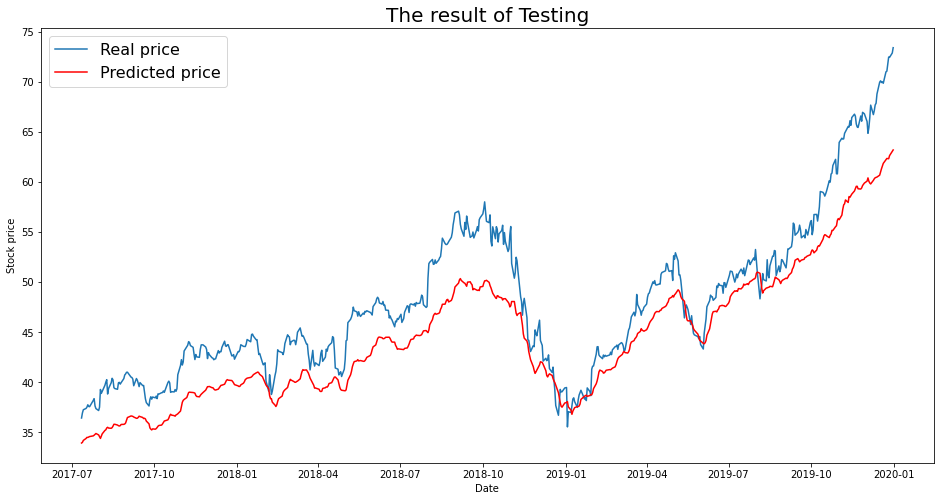

----- Test_RMSE_LSTM ----- 3.9961777312880056


In [10]:
test_RMSE = plot_testdataset_result(X_test, y_test)
print("----- Test_RMSE_LSTM -----", test_RMSE)